In [1]:
import numpy as np 
import pandas as pd
from tensorflow.keras.applications import ResNet50

In [2]:
og_df = pd.read_csv('labels.csv')

In [3]:
og_df['label'].value_counts()

label
2    1426
3     930
1     708
Name: count, dtype: int64

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [5]:
df = og_df.copy()

In [6]:
df['label'] = df['label'] - df['label'].min()

In [7]:
# Image directory and resize config
img_dir = 'C:/Users/User/dimaag/png_images'
IMG_SIZE = (224, 224)

In [8]:
# Preload all images and labels into NumPy arrays
images = []
labels = []

for _, row in df.iterrows():
    img_path = os.path.join(img_dir, row['filename'])
    image = load_img(img_path, target_size=IMG_SIZE)
    image = img_to_array(image) / 255.0
    label = row['label']
    images.append(image)
    labels.append(label)

In [9]:
# Convert to NumPy arrays first
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

In [10]:
#Now split the NumPy arrays
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

In [11]:
#Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val   = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val   = tf.convert_to_tensor(y_val, dtype=tf.int32)

In [12]:
df['label'].value_counts()

label
1    1426
2     930
0     708
Name: count, dtype: int64

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential, Input
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

resnet_model = Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train if needed:
resnet_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3782 - loss: 1.2874 - val_accuracy: 0.4666 - val_loss: 1.0025
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4983 - loss: 1.0035 - val_accuracy: 0.5775 - val_loss: 0.9205
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.5621 - loss: 0.9374 - val_accuracy: 0.6444 - val_loss: 0.8564
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6032 - loss: 0.8765 - val_accuracy: 0.6786 - val_loss: 0.7903
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6252 - loss: 0.8300 - val_accuracy: 0.6656 - val_loss: 0.7478
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6346 - loss: 0.7958 - val_accuracy: 0.6966 - val_loss: 0.7479
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6689 - loss: 0.7540 - val_accuracy: 0.7162 - val_loss: 0.6661
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6827 - loss: 0.7174 - val_accuracy: 0.7210 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 930ms/step

Classification Report (ResNet50):
              precision    recall  f1-score   support

  Meningioma       0.78      0.28      0.41       142
      Glioma       0.70      0.91      0.79       285
   Pituitary       0.84      0.85      0.84       186

    accuracy                           0.75       613
   macro avg       0.77      0.68      0.68       613
weighted avg       0.76      0.75      0.72       613



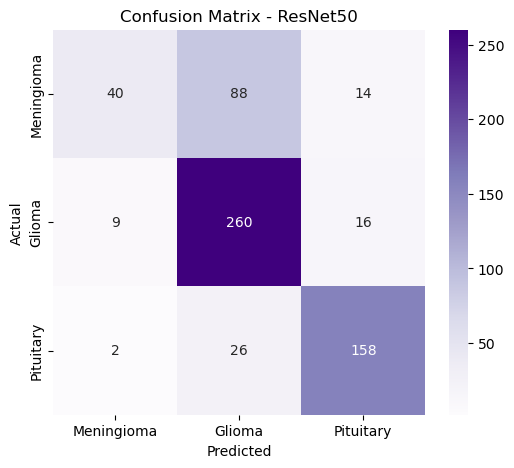

ResNet50 Accuracy: 0.7471


In [18]:
y_pred_probs = resnet_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_val.numpy() if isinstance(y_val, tf.Tensor) else y_val

print("\nClassification Report (ResNet50):")
class_names = ["Meningioma", "Glioma", "Pituitary"]
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet50")
plt.show()

print(f"ResNet50 Accuracy: {accuracy_score(y_true, y_pred):.4f}")